<a href="https://colab.research.google.com/github/arturbernardo/data_stars/blob/main/Hertzsprung_Russell_diagram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyvo
!pip install mocpy
!pip install astropy
!pip install ipyaladin
!pip install astroquery

In [ ]:
from pyvo import registry  # version >=1.6
from mocpy import MOC
from astropy.coordinates import SkyCoord
from ipyaladin import Aladin  # version >=0.4.0
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.colors import LinearSegmentedColormap

https://astroquery.readthedocs.io/en/latest/gaia/gaia.html

Load table com Gaia 3, the database from the European Space Agency's (ESA) Gaia mission

In [ ]:
from astroquery.gaia import Gaia
gaiadr3_table = Gaia.load_table('gaiadr3.gaia_source')
print(gaiadr3_table)

Import data from 10000 stars.
The filters are there to avoid records with to many uncertainty.
There are no best values, I dicided by this ones on try and error.

bp_rp is necessary to know the color of the star.

visibility_periods_used periods used increase the chance of good quality mesurements.

photo_g_mean_mag is the magnitude of the star captured by the camera lense.


In [ ]:
job = Gaia.launch_job("""
    SELECT TOP 10000
        parallax, bp_rp, phot_g_mean_mag,
        phot_bp_mean_flux_over_error,
        phot_rp_mean_flux_over_error,
        visibility_periods_used,
        astrometric_chi2_al,
        astrometric_n_good_obs_al,
        astrometric_primary_flag
    FROM gaiadr3.gaia_source
    WHERE
        parallax > 0
        AND parallax_over_error > 5
        AND phot_g_mean_mag IS NOT NULL
        AND bp_rp IS NOT NULL
        AND phot_bp_mean_flux_over_error > 5
        AND phot_rp_mean_flux_over_error > 5
        AND visibility_periods_used > 5
        AND astrometric_chi2_al / (astrometric_n_good_obs_al - 5) < 2.5
    ORDER BY random_index
""")

r = job.get_results()
df = r.to_pandas()

# Magnitude of the star:

This formula derivate from the inverse square of the distance.

Recieved Light = Star light / distance ** 2

If the observer is twice as far, the light will dim by a factor of 4.

If the distance is three times greater, the light dims by 9.

At ten times the distance, the light dims by 100.

This happens because light spreads out in all directions, forming an ever-expanding sphere. So we use the surface area of a sphere to model it:

I = L/4πd**2

The formula for magnitude is a bit arbitrary, because it preserves a scale that dates back to ancient Greece. In modern times, we define a star’s absolute magnitude as the brightness it would have if it were 10 parsecs away.

The constant 5 comes from the fact that a difference of 5 magnitudes corresponds to a factor of 100 in brightness.

After some derivation, we get this shortcut formula:

Magnitude = light captured at earth + 5 * log10(distance of the star) - 5

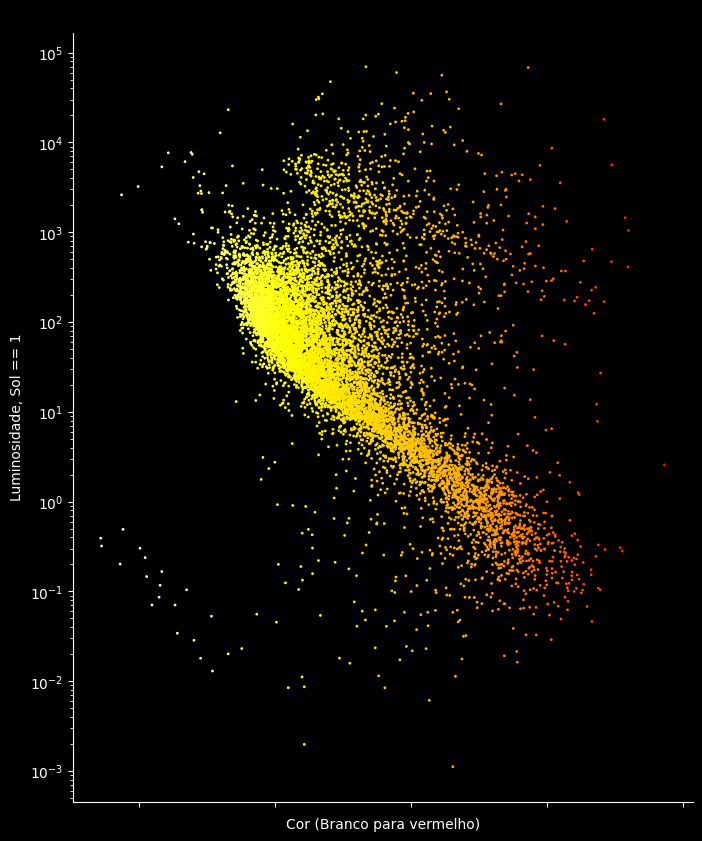

In [ ]:
# Sun magnitude
M_sun = 4.83

# Magnitude = light captured at earth + 5 * log10(distance of the star) - 5
df['M'] = df['phot_g_mean_mag'] + 5 * np.log10(df['parallax']/100) - 5

# Magnitude compared with the sun
df['log_L'] = -0.4 * (df['M'] - M_sun)

#log magnitude. Some start shine hundred of thousands more then others
df['L'] = 10 ** df['log_L']

# Color spectrum
colors = ['white', 'yellow', 'orange', 'red']
n_bins = 500
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=n_bins)

fig, ax = plt.subplots()
ax.set_xticklabels([])
fig.set_figheight(10)
fig.set_figwidth(8)

fig.patch.set_facecolor('black')
ax.set_facecolor('black')

ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.tick_params(colors='white', which='both')

ax.set_yscale('log')
plt.scatter(df['bp_rp'], df['L'], s=1, c=df['bp_rp'], cmap=cmap)
plt.xlabel('Cor (Branco para vermelho)')
plt.ylabel('Luminosidade, Sol == 1')
plt.title('Diagrama HR')
plt.grid(False)

plt.show()


To better understandment of the values, pandas can help us with min, max, mean and other informations from the dataframe.

In [ ]:
print(df['log_L'].describe())
print(df['L'].describe())
print(df['M'].describe())

In [ ]:
# BP - RP ~ 0.2 a 0.5 → Estrela quente, tipo espectral de A ou F (branca a amarela).

# BP - RP ~ 0.5 a 1.0 → Estrela de tipo G (amarela, como o Sol).

# BP - RP ~ 1.0 a 1.5 → Estrela de tipo K (laranja).

# BP - RP > 1.5 → Estrela de tipo M (vermelha).